# SM2 — Summer Behavior of Corridors (NP) and Garages (PP)

This notebook explores **secondary overheating issues** using **ThermoPro** data:

1. **Corridors (NP)** — focus on **5NP** to compare sections (staircase corridors). Some sections may have limited ventilation (e.g., non-openable windows), affecting heat dissipation.
2. **Garages (PP)** — overheating driven by **split AC units located in 1PP**, with heat distributed into lower levels (2PP, 3PP) by the concrete skeleton.

### Goals
- Focus on **meteorological summer** (June 1 – Aug 31) for **2024** and **2025** (local time, Europe/Prague).
- **Corridors 5NP:** compare sections by daily maxima, counts of days ≥ 27 °C, distributions, and hour-of-day patterns.
- **Garages PP:** use the **top 5 PP locations by data volume**, summarize and visualize their summer behavior, including counts of days ≥ 27 °C.


In [1]:
try:
    import pandas as pd
    import matplotlib
except Exception:
    %pip install -q pandas pyarrow matplotlib gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os, re

plt.rcParams['figure.figsize'] = (12, 6)
OUT_DIR = Path('outputs'); OUT_DIR.mkdir(exist_ok=True)


## Download & load data

In [2]:
PARQUET_ID = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"
CSVGZ_ID  = "1eLOAOZ13--EKE63GZhmerjmY9zkeJcyd"
USE_PARQUET = True

parquet_path = Path('sm2_public_dataset.parquet')
csvgz_path   = Path('sm2_public_dataset.csv.gz')

def gdown_download(file_id: str, out_path: Path):
    import subprocess, sys
    try:
        import gdown  # type: ignore
    except Exception:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'gdown'])
        import gdown  # type: ignore
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

if USE_PARQUET:
    if not parquet_path.exists():
        print('Downloading Parquet…')
        gdown_download(PARQUET_ID, parquet_path)
else:
    if not csvgz_path.exists():
        print('Downloading CSV.GZ…')
        gdown_download(CSVGZ_ID, csvgz_path)

if USE_PARQUET and parquet_path.exists():
    df = pd.read_parquet(parquet_path)
elif csvgz_path.exists():
    df = pd.read_csv(csvgz_path, compression='gzip')
else:
    raise FileNotFoundError('Dataset not found. Check IDs or internet access.')

df['time'] = pd.to_datetime(df['time'], utc=True, errors='coerce')
df['data_value'] = pd.to_numeric(df['data_value'], errors='coerce')
print('Shape:', df.shape)
df.head(3)


Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 63.2MB/s]


Shape: (651332, 6)


,time,location,source,measurement,data_key,data_value
0,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_ambient,4.0
1,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_fresh,20.3
2,2023-11-30 13:00:00+00:00,sm2_01,Atrea,nonadditive,temp_indoor,21.4


## Helper functions & filters

- We use **ThermoPro / `temp_indoor`** as corridor/garage temperature.
- Daily aggregates in **Europe/Prague**.
- **Summer window** per year: June 1 – Aug 31 (inclusive).

In [3]:
thermo = df[(df['source']=='ThermoPro') & (df['data_key']=='temp_indoor')].copy()
thermo['local_time'] = thermo['time'].dt.tz_convert('Europe/Prague')
thermo['local_day'] = thermo['local_time'].dt.floor('D')
thermo['year'] = thermo['local_time'].dt.year

def is_np(loc: str) -> bool:
    return isinstance(loc, str) and 'NP' in loc
def is_pp(loc: str) -> bool:
    return isinstance(loc, str) and 'PP' in loc

THERESH = 27.0
SUMMER_START = {2024: pd.Timestamp('2024-06-01', tz='Europe/Prague'), 2025: pd.Timestamp('2025-06-01', tz='Europe/Prague')}
SUMMER_END   = {2024: pd.Timestamp('2024-08-31', tz='Europe/Prague'), 2025: pd.Timestamp('2025-08-31', tz='Europe/Prague')}


## Part A — Corridors (5NP): section comparison (2024 & 2025)

We filter `location` like `5NP-S*` and compute:
- Daily maxima per section and summer year
- Count of days with daily max ≥ 27 °C (and rate vs observed days)
- Distribution (boxplot) per section per year
- Hour-of-day mean profile per section (summer window)

In [4]:
tp_5np = thermo[thermo['location'].str.startswith('5NP-S', na=False)].copy()
print('Rows 5NP:', len(tp_5np))

def summer_filter(frame: pd.DataFrame, year: int) -> pd.DataFrame:
    if year not in SUMMER_START:
        return frame.iloc[0:0]
    mask = (frame['local_day']>=SUMMER_START[year]) & (frame['local_day']<=SUMMER_END[year])
    return frame.loc[mask].copy()

def daily_max(frame: pd.DataFrame) -> pd.DataFrame:
    d = (frame.groupby(['location','local_day'])['data_value']
               .max()
               .reset_index(name='daily_max'))
    d['year'] = d['local_day'].dt.year
    return d

tp_5np_daily = daily_max(tp_5np)

def summer_summary(d: pd.DataFrame, year: int) -> pd.DataFrame:
    sub = summer_filter(d, year)
    if sub.empty:
        return sub
    out = (sub.groupby('location')
               .agg(days_observed=('local_day','nunique'),
                    days_over_27=('daily_max', lambda s: int((s>=THERESH).sum())),
                    max_of_max=('daily_max','max'),
                    p95=('daily_max', lambda s: float(np.nanpercentile(s,95))))
               .reset_index())
    out['rate_over_27_%'] = (100.0 * out['days_over_27'] / out['days_observed']).round(2)
    out['year'] = year
    return out

sum_2024 = summer_summary(tp_5np_daily, 2024)
sum_2025 = summer_summary(tp_5np_daily, 2025)
tp_5np_summary = pd.concat([sum_2024, sum_2025], ignore_index=True)
display(tp_5np_summary.sort_values(['year','days_over_27'], ascending=[True, False]))
tp_5np_summary.to_csv(OUT_DIR / 'thermopro_5np_summer_summary.csv', index=False)
print('Saved:', OUT_DIR / 'thermopro_5np_summer_summary.csv')


Rows 5NP: 5032


,location,local_day,daily_max,year,days_observed,days_over_27,max_of_max,p95,rate_over_27_%
2,5NP-S3,NaT,NaN,2025,84.0,78.0,31.758333,30.992167,92.86
6,5NP-S7,NaT,NaN,2025,27.0,24.0,28.761667,28.732667,88.89
8,5NP-S9,NaT,NaN,2025,12.0,8.0,28.058333,27.985000,66.67
1,5NP-S2,NaT,NaN,2025,10.0,5.0,28.221667,28.031917,50.00
7,5NP-S8,NaT,NaN,2025,12.0,5.0,28.451667,28.151000,41.67
0,5NP-S1,NaT,NaN,2025,10.0,4.0,27.570000,27.486750,40.00
4,5NP-S5,NaT,NaN,2025,27.0,3.0,28.196667,27.754833,11.11
3,5NP-S4,NaT,NaN,2025,10.0,1.0,27.350000,27.010250,10.00
5,5NP-S6,NaT,NaN,2025,12.0,1.0,27.250000,27.057500,8.33


Saved: outputs/thermopro_5np_summer_summary.csv


No 5NP data for 2024


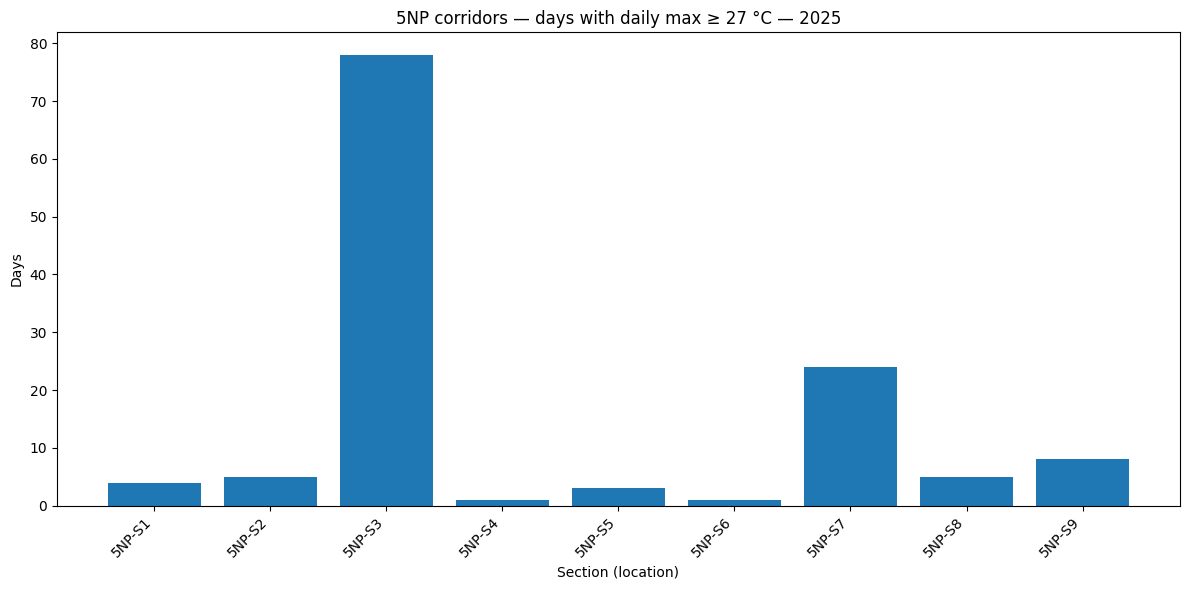

Saved: outputs/5np_days_over27_2025.png


In [5]:
# Bar charts per year
for y in [2024, 2025]:
    sub = tp_5np_summary[tp_5np_summary['year']==y].sort_values('location')
    if sub.empty:
        print(f'No 5NP data for {y}')
        continue
    fig = plt.figure()
    ax = plt.gca()
    ax.bar(sub['location'].astype(str), sub['days_over_27'].astype(int))
    ax.set_title(f'5NP corridors — days with daily max ≥ 27 °C — {y}')
    ax.set_xlabel('Section (location)')
    ax.set_ylabel('Days')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f'5np_days_over27_{y}.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / f'5np_days_over27_{y}.png')


No 5NP summer data for 2024


/tmp/ipython-input-2304993165.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_lists, labels=locations)


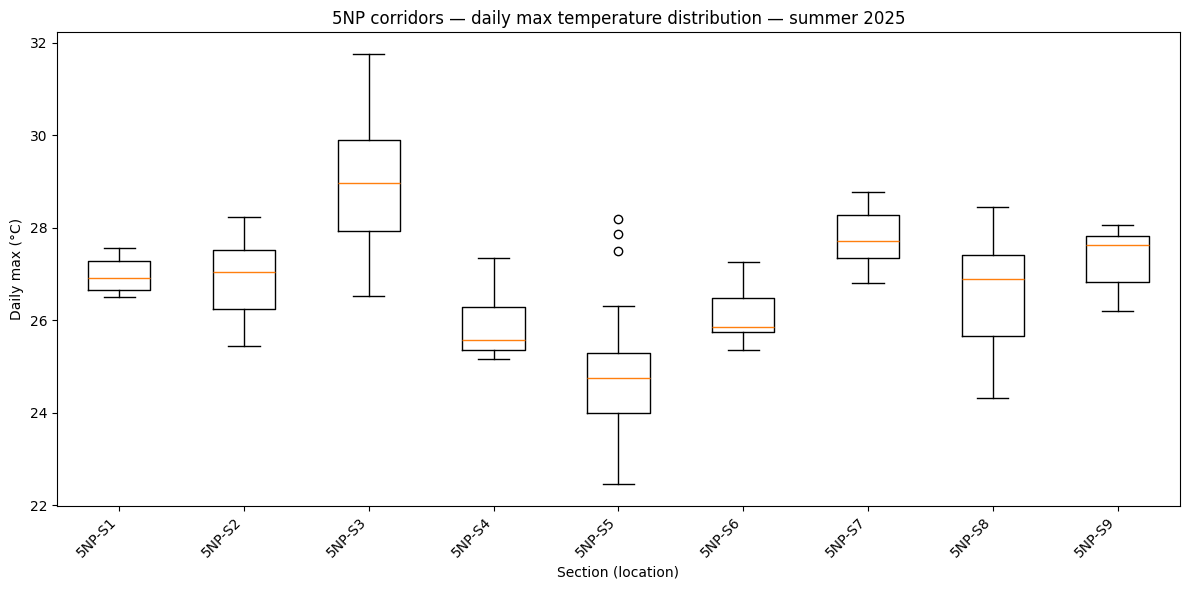

Saved: outputs/5np_dailymax_boxplot_summer_2025.png


In [6]:
# Boxplots by section (summer per year)
for y in [2024, 2025]:
    sub = summer_filter(tp_5np_daily, y)
    if sub.empty:
        print(f'No 5NP summer data for {y}')
        continue
    locations = sorted(sub['location'].unique())
    data_lists = [sub.loc[sub['location']==loc, 'daily_max'].dropna().values for loc in locations]
    fig = plt.figure()
    ax = plt.gca()
    ax.boxplot(data_lists, labels=locations)
    ax.set_title(f'5NP corridors — daily max temperature distribution — summer {y}')
    ax.set_xlabel('Section (location)')
    ax.set_ylabel('Daily max (°C)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f'5np_dailymax_boxplot_summer_{y}.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / f'5np_dailymax_boxplot_summer_{y}.png')


No 5NP summer raw data for 2024


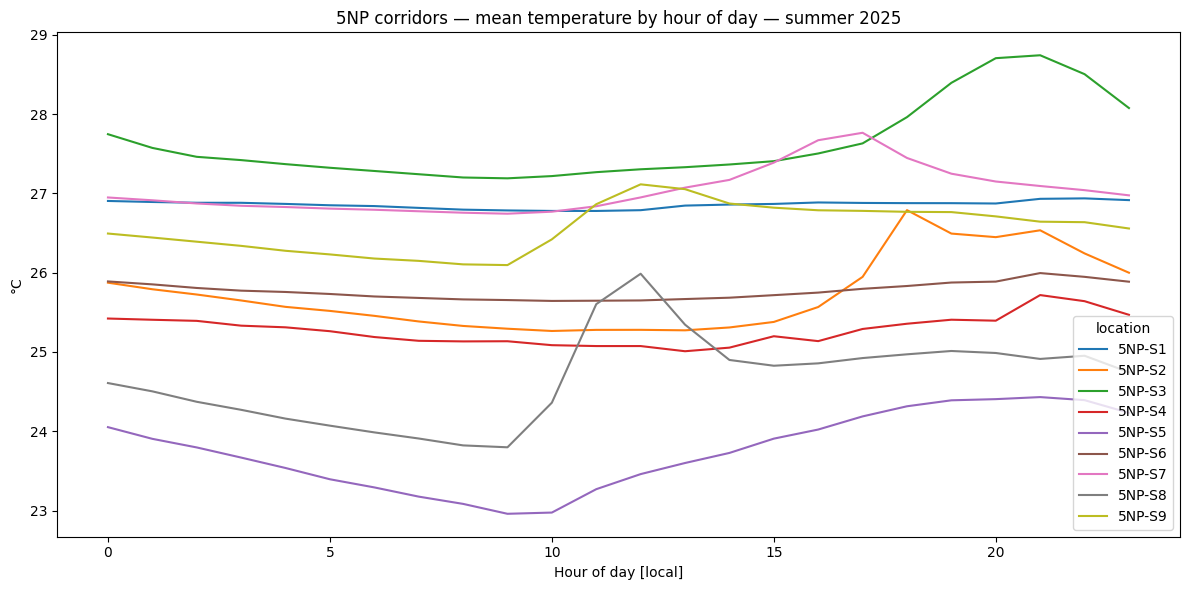

Saved: outputs/5np_hod_profile_summer_2025.png


In [7]:
# Hour-of-day profile per section, summer (averaged)
for y in [2024, 2025]:
    s = summer_filter(tp_5np, y)
    if s.empty:
        print(f'No 5NP summer raw data for {y}')
        continue
    s['hod'] = s['local_time'].dt.hour
    piv = s.pivot_table(index='hod', columns='location', values='data_value', aggfunc='mean')
    fig = plt.figure()
    ax = plt.gca()
    piv.plot(ax=ax, legend=True)
    ax.set_title(f'5NP corridors — mean temperature by hour of day — summer {y}')
    ax.set_xlabel('Hour of day [local]')
    ax.set_ylabel('°C')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f'5np_hod_profile_summer_{y}.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / f'5np_hod_profile_summer_{y}.png')


## Part B — Garages (PP): top 5 locations by data volume

We select **PP** locations (1PP, 2PP, 3PP), find **top 5** by row count, and analyze their summer 2024 & 2025 behavior.

In [8]:
tp_pp = thermo[thermo['location'].str.contains('PP', na=False)].copy()
top5 = (tp_pp['location'].value_counts().head(5).index.tolist())
print('Top 5 PP locations:', top5)

tp_pp_top = tp_pp[tp_pp['location'].isin(top5)].copy()

pp_daily = (tp_pp_top.groupby(['location','local_day'])['data_value']
                        .max()
                        .reset_index(name='daily_max'))
pp_daily['year'] = pp_daily['local_day'].dt.year

def summer_filter(frame: pd.DataFrame, year: int) -> pd.DataFrame:
    mask = (frame['local_day']>=pd.Timestamp(f'{year}-06-01', tz='Europe/Prague')) & (frame['local_day']<=pd.Timestamp(f'{year}-08-31', tz='Europe/Prague'))
    return frame.loc[mask].copy()

def summer_summary_pp(d: pd.DataFrame, year: int) -> pd.DataFrame:
    sub = summer_filter(d, year)
    if sub.empty:
        return sub
    out = (sub.groupby('location')
               .agg(days_observed=('local_day','nunique'),
                    days_over_27=('daily_max', lambda s: int((s>=27.0).sum())),
                    max_of_max=('daily_max','max'),
                    p95=('daily_max', lambda s: float(np.nanpercentile(s,95))))
               .reset_index())
    out['rate_over_27_%'] = (100.0 * out['days_over_27'] / out['days_observed']).round(2)
    out['year'] = year
    return out

pp_sum_2024 = summer_summary_pp(pp_daily, 2024)
pp_sum_2025 = summer_summary_pp(pp_daily, 2025)
pp_summary = pd.concat([pp_sum_2024, pp_sum_2025], ignore_index=True)
display(pp_summary.sort_values(['year','days_over_27'], ascending=[True, False]))
pp_summary.to_csv(OUT_DIR / 'thermopro_pp_top5_summer_summary.csv', index=False)
print('Saved:', OUT_DIR / 'thermopro_pp_top5_summer_summary.csv')


Top 5 PP locations: ['1PP-S1', '2PP-S9', '3PP-S9', '2PP-S1', '3PP-S5']


,location,local_day,daily_max,year,days_observed,days_over_27,max_of_max,p95,rate_over_27_%
0,1PP-S1,NaT,NaN,2025,90.0,90.0,34.583333,34.329583,100.0
1,2PP-S1,NaT,NaN,2025,25.0,16.0,28.821667,28.693667,64.0
2,2PP-S9,NaT,NaN,2025,27.0,1.0,27.031667,26.735000,3.7
3,3PP-S5,NaT,NaN,2025,25.0,1.0,27.094737,25.311000,4.0
4,3PP-S9,NaT,NaN,2025,27.0,0.0,26.582353,25.215167,0.0


Saved: outputs/thermopro_pp_top5_summer_summary.csv


No PP top5 summer data for 2024


/tmp/ipython-input-2395738233.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_lists, labels=locations)


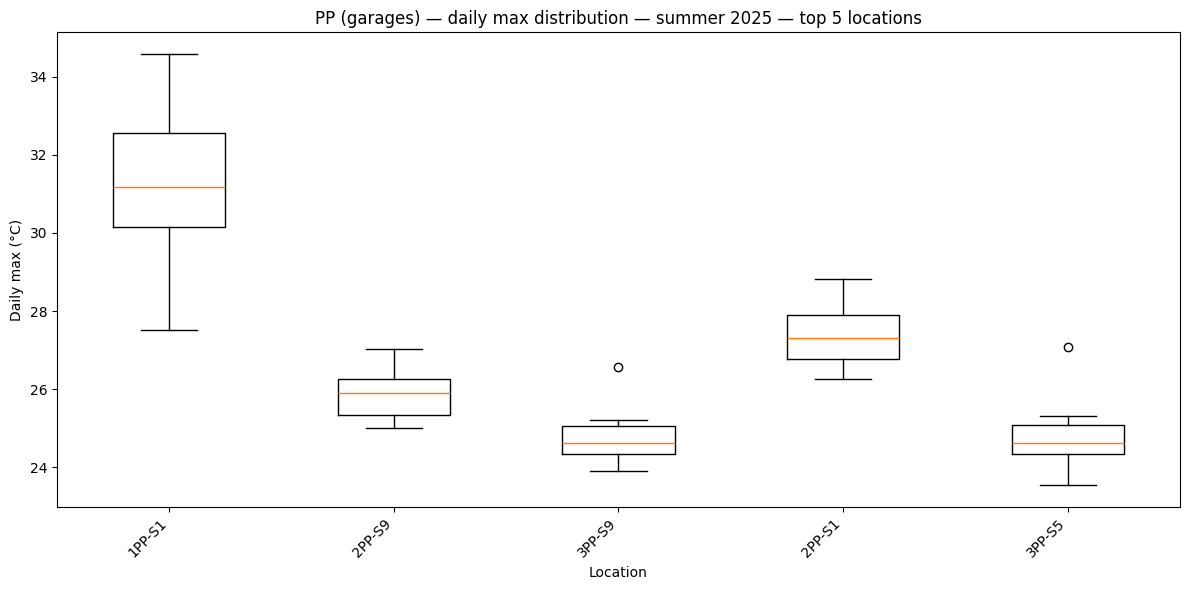

Saved: outputs/pp_top5_dailymax_boxplot_summer_2025.png


In [9]:
# Boxplots per year for top5 PP locations
for y in [2024, 2025]:
    sub = summer_filter(pp_daily, y)
    if sub.empty:
        print(f'No PP top5 summer data for {y}')
        continue
    locations = [loc for loc in top5 if loc in sub['location'].unique()]
    data_lists = [sub.loc[sub['location']==loc, 'daily_max'].dropna().values for loc in locations]
    fig = plt.figure()
    ax = plt.gca()
    ax.boxplot(data_lists, labels=locations)
    ax.set_title(f'PP (garages) — daily max distribution — summer {y} — top 5 locations')
    ax.set_xlabel('Location')
    ax.set_ylabel('Daily max (°C)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f'pp_top5_dailymax_boxplot_summer_{y}.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / f'pp_top5_dailymax_boxplot_summer_{y}.png')


No PP summary for 2024


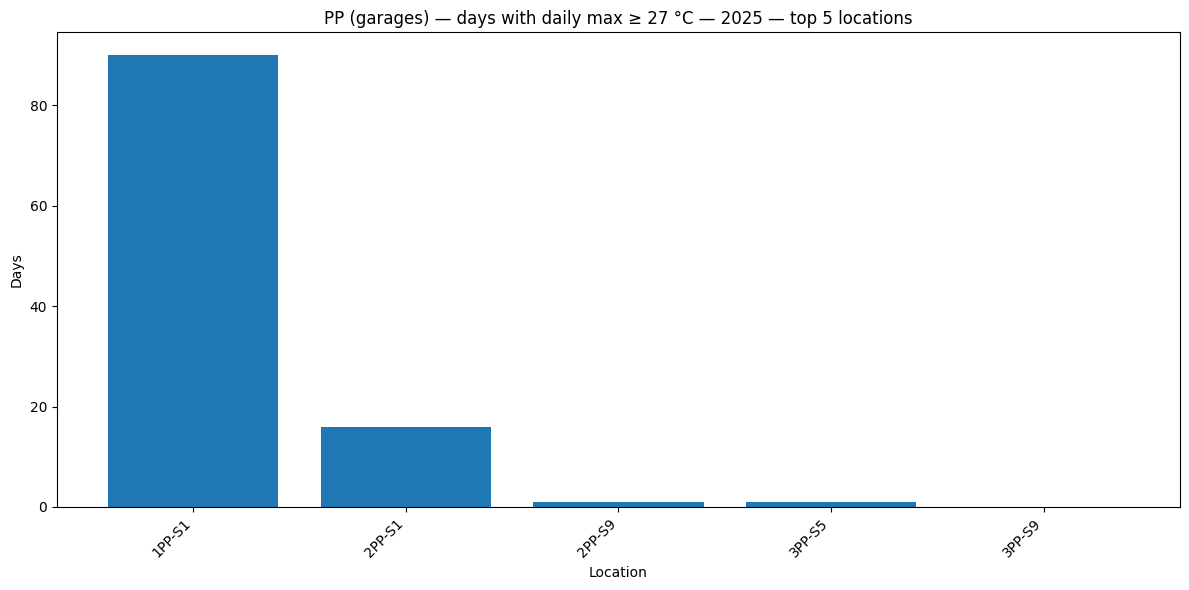

Saved: outputs/pp_top5_days_over27_2025.png


In [10]:
# Bar charts: days ≥ 27 °C per location per year
for y in [2024, 2025]:
    sub = pp_summary[pp_summary['year']==y].sort_values('location')
    if sub.empty:
        print(f'No PP summary for {y}')
        continue
    fig = plt.figure()
    ax = plt.gca()
    ax.bar(sub['location'].astype(str), sub['days_over_27'].astype(int))
    ax.set_title(f'PP (garages) — days with daily max ≥ 27 °C — {y} — top 5 locations')
    ax.set_xlabel('Location')
    ax.set_ylabel('Days')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(OUT_DIR / f'pp_top5_days_over27_{y}.png', dpi=150)
    plt.show()
    print('Saved:', OUT_DIR / f'pp_top5_days_over27_{y}.png')


## Notes & interpretation
- Corridor differences across sections may align with **ventilation options** (e.g., non-openable windows). If you maintain metadata per section about window operability, add a mapping and stratify results.
- Garage overheating is expected to be **strongest in 1PP**; the concrete skeleton distributes heat to lower levels.
- For a stricter definition, you may add a **30 °C** threshold and compute the same KPIs.
